# Convolutional Neural Network (ConvNet/CNN)

Convolutional Neural Networks (ConvNet/CNN) are Deep Learning models that can take an input image, assign relevance (learnable weights and biases) to various aspects/objects in the image, and distinguish between them. <br />



<center><img src="./_dependents/rgb.png" width="500" /></center>

You often see images divided into three colour planes — Red, Green, and Blue — RGB. <br />
But they can be stored in a variety of colour spaces, including Grayscale, RGB, HSV, CMYK, and others. <br />


With the basic machine learning techniques, it is required to hand-engineering features and analyse the figures dimension by dimension. 
Imagine now taking a photo which exceeds 8K (7680x4320) dimensions and how computationally intensive it will be.
The ConvNet's job is to compress the images into a format that is easier to process while preserving elements that are important for obtaining a decent prediction. This is critical for designing an architecture that is capable of learning features while also being scalable to large datasets. <br />
So, while basic machine learning techniques require hand-engineering of features, ConvNets can learn these filters/characteristics through training.


Below an example of a CNN architecture for classification. Starting from a picture, it analyses through its layers and output the correct class of object present in the image (a car in this case)

<center><img src="./_dependents/basic_architecture.png" width="800" /></center>


## Using PyTorch for creating a CNN architecture

In this experiment we will use the ```PyTorch``` library for creating our own CNN model.

First of all, let us import the necessary libraries with the following commands:

In [1]:
import torch # PyTorch is an open source machine learning framework.
import torchvision # The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.
from torchvision import transforms
from PIL import Image # PIL is a library to process images
import numpy as np # package to work with numbers
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix


d:\Anaconda3\envs\imperial\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We can create a ```device``` variable to check if a GPU is available.
If the output of device variable is 'cuda', then it means that PyTorch will use a GPU for the analysis. Otherwise, CPU is used instead.

In [2]:
# Device configuration
print('GPU available: {}' .format(torch.cuda.is_available())) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_on_gpu = torch.cuda.is_available()

device


GPU available: True
NVIDIA GeForce RTX 3070


device(type='cuda')

## Load CIFAR10 Dataset

We will now download the ```CIFAR10``` dataset that we will use for the laboratory and save it in a root folder path called 'data'. ```CIFAR10``` is a dataset used for image recognition that is commonly used for training image processing systems. The dataset is made up of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


Additional information on the dataset can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html)

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.CIFAR10(
    root = 'dataset', # path where the data will be downloaded
    train = True,  # true if you want to download the training set, false for the testing set                        
    transform = transform, # transform the data into a tensor that will be used later for analysis
    download = True,            
)

test_data = datasets.CIFAR10(
    root = 'dataset', 
    train = False, 
    transform = ToTensor()
)

print(train_data)
print('------')
print(test_data)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dataset
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: dataset
    Split: Test
    StandardTransform
Transform: ToTensor()


Let's examine the training data with a random index

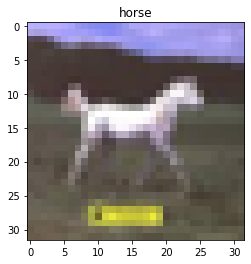

In [4]:
import matplotlib.pyplot as plt
import random

idx = random.randint(0, train_data.data.shape[0])

plt.imshow(train_data.data[idx], cmap='gray')
plt.title('%s' % classes[train_data.targets[idx]])
plt.show()


## Preparing data with DataLoader

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting.

```DataLoader``` is an iterable variable that we can use in PyTorch to automatically perform these functions.

For additional information on ```DataLoader```, you can refer to the [official documentation](https://pytorch.org/docs/stable/data.html)

First let's split our training set into training and validation. Validation can be used for testing the scores of our model during training.

In [5]:
validation_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(validation_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

Below we will load the dataset into DataLoader of batch_size=64 features and labels respectively. 

In [6]:
from torch.utils.data import DataLoader

batch_size=64
shuffle_data =  True

train_dataloader = DataLoader(train_data, 
                              batch_size=batch_size, 
                              sampler=train_sampler)

val_dataloader = DataLoader(train_data, 
                              batch_size=batch_size, 
                              sampler=valid_sampler)

test_dataloader = DataLoader(test_data, 
                             batch_size=batch_size,
                             shuffle=shuffle_data)

We can iterate over the DataLoader variable and extracting the features of the image and the corresponding label

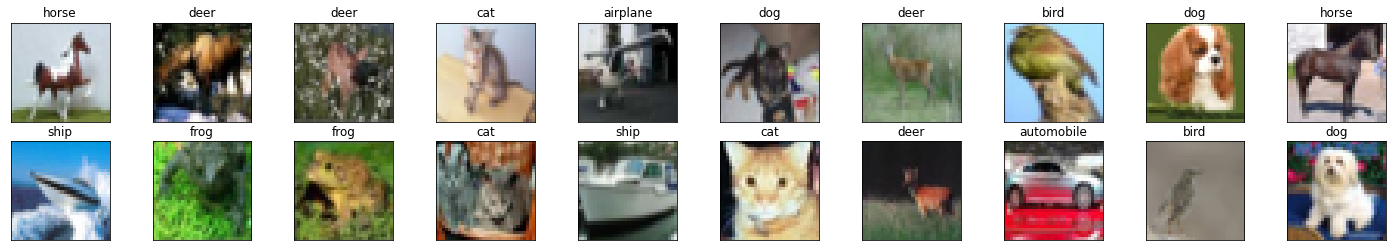

In [7]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()  # if this line gives you error, change it into: images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
images.shape

## Create CNN Architecture

We will now create the architecture for the CNN. In this example we will use two convolutional layers followed by three fully-connected layers. 

When creating the network, we also need to specify the activation function of each layer. We will use the Rectified Linear Units (ReLU) in this case.

If necessary, we can also introduce a regularisation layer to reduce possible overfitting. A simple way to do this can be to use dropout layers.


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# define the CNN architecture

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #n_channels = 3, rgb image. These parameters can be modified and optimised based on the task and/or dataset
        self.pool = nn.MaxPool2d(2, 2) # Applies 2D max-pooling to reduce the spatial dimensions of the input volume
        self.conv2 = nn.Conv2d(6, 16, 5)
        #self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # Fully connected layers
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 10)
    
    
    # The forward pass defines the way we compute the output using the given layers and functions.
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # activation function
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.conv2_drop(x)
        x = x.view(-1, 16 * 5 * 5)  # Flattens the output of a multi-dimensional volume 
                                    # such that we can apply fully connected layers to it
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# create the model CNN
model = CNN()

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

We can print the architecture of the CNN network to investigate its layers

In [ ]:
print(model)

## Define Loss and Optimser 

**Loss**

Deep neural network are trained via an algorithm called stochastic gradient descent optimization.
It is necessary to repeatedly estimate the error for the model's current state as part of the optimiaation method. In order to update the weights and lower the loss on the subsequent evaluation, it is necessary to select an error function, also known as a loss function, that may be used to estimate the loss of the model.

There exist multiple and different losses based on the scope of the analysis.
In this experiment, we are interested in classifying the number present in the image. We are then performing a multi-class classification. Our goal is to predict the probability of the sample belonging to each known class (from number 0 to 9).

We can then use a loss called ```Cross-entropy```. It will calculate a score to summarise the average difference between the actual and predicted probability distributions for all classes. To achieve the best results we have to minimise this loss



**Optimiser**

When training the model, we need to minimise the loss function and update the weights of the model at each epoch. 
In other words, we need to optimise the neural network.
An optimiser is a function or an algorithm that modifies the attributes of the neural network, such as weights and learning rate. It works for reducing the loss and improve the overall accuracy.

There are various types of optimiser. In our case, we will use ```Adam``` which is one of the most popular gradient descent optimisation algorithms.

When setting up the optimiser, we also need to decide at which speed the model will learn. This is done via the learning rate.
It will tell the model how fast or slow we will move towards the optimal weights
<center><img src="./_dependents/learning_rate.png" width="300" /></center>

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)  # cross-entropy loss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

optimizer

## Train the model

We have finally set up all the parameters and we can move on to train the model on our dataset.
We need to set the number of iterations that we want to train our model. This number needs to be carefully decided: if it is too low, then we risk of underfitting our model, if it is too high, we risk of overfitting it.
<center><img src="./_dependents/overfitting_model.png" width="300" /></center>

In [17]:
# create the model CNN
model = CNN()

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

    
criterion = torch.nn.CrossEntropyLoss().to(device)  # cross-entropy loss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
# number of epochs to train the model
n_epochs = 5

#List to store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    print('[INFO] TRAINING EPOCH {}'.format(epoch))
    model.train()
    for data, target in train_dataloader:
        # move tensors to GPU if CUDA is available
        # if train_on_gpu:
        #     data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_dataloader.dataset)
    train_losslist.append(train_loss)
    print('[INFO] Epoch {}, Training Loss: {:.6f}'.format(epoch, train_loss))
        
    ######################    
    # validate the model #
    ######################
    print('[INFO] VALIDATION EPOCH {}'.format(epoch))
    model.eval()
    for data, target in val_dataloader:
        # move tensors to GPU if CUDA is available
        # if train_on_gpu:
        #     data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    valid_loss = valid_loss/len(val_dataloader.dataset)
    print('[INFO] Epoch {}, Validation Loss: {:.6f}'.format(epoch, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
    print('-----------------------------------------------------------')    

plt.plot([*range(n_epochs)], train_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.show()


[INFO] TRAINING EPOCH 1
[INFO] Epoch 1, Training Loss: 1.441293
[INFO] VALIDATION EPOCH 1
[INFO] Epoch 1, Validation Loss: 0.305656
Validation loss decreased (inf --> 0.305656).  Saving model ...
-----------------------------------------------------------
[INFO] TRAINING EPOCH 2
[INFO] Epoch 2, Training Loss: 1.208449
[INFO] VALIDATION EPOCH 2
[INFO] Epoch 2, Validation Loss: 0.274612
Validation loss decreased (0.305656 --> 0.274612).  Saving model ...
-----------------------------------------------------------
[INFO] TRAINING EPOCH 3
[INFO] Epoch 3, Training Loss: 1.118767
[INFO] VALIDATION EPOCH 3
[INFO] Epoch 3, Validation Loss: 0.255395
Validation loss decreased (0.274612 --> 0.255395).  Saving model ...
-----------------------------------------------------------
[INFO] TRAINING EPOCH 4
[INFO] Epoch 4, Training Loss: 1.047516
[INFO] VALIDATION EPOCH 4
[INFO] Epoch 4, Validation Loss: 0.234214
Validation loss decreased (0.255395 --> 0.234214).  Saving model ...
---------------------

## Test the model

We will now load the model which achieved the best results during training and we will test it on the testing set

In [ ]:
model.load_state_dict(torch.load('model_cifar.pt'))

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

total_test_predicted_labels = []
total_test_true_labels = []

model.eval()
# iterate over test data
for data, target in test_dataloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    total_test_true_labels.append(target.cpu().numpy())
    total_test_predicted_labels.append(pred.cpu().numpy())

    # calculate test accuracy for each object class
    for i in range(target.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
        
y_true = np.asarray([item for sublist in total_test_true_labels for item
                             in sublist])
y_pred = np.asarray([item for sublist in total_test_predicted_labels for
                               item in sublist])        

# average test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

## Investigate results

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
cf = confusion_matrix(y_true, y_pred)
# cf_norm = confusion_matrix(y_true, y_pred, normalize='true') * 100

print('ACCURACY: {:.2f}\n RECALL: {:.2f}\n PRECISION: {:.2f}\n F1: {:.2f}\n  '.format(accuracy, 
                                                                                      recall,
                                                                                      precision, 
                                                                                      f1))
print(cf)

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cf, annot=True, ax = ax, cmap='Blues', fmt='g')
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
plt.show()

# Useful Resources

- Documentation for the Convolutional Layer - https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html 
- Guide and discussion on optimisers - https://medium.com/mlearning-ai/optimizers-in-deep-learning-7bf81fed78a0
- CIFAR10 Tutorial - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- CNN implementation on CIFAR10 - https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844